In [35]:
import numpy as np
import pandas as pd
import nltk
import sklearn 
from collections import Counter
import string
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import random
import matplotlib.pyplot as plt 

## Meople without particular political affiliation hear more democrates news

I used data from the data set of the answers to a survey of people's attitude towards the Internet, where there were two questions regarding political affiliation, namely, what was the political affiliation of the person, and if they hear more news about Democrat or Republican party. I choose a subset of people who check their social networks more than once per day and do not have particular political affilitiation to derive conclusions. Basically, if someone opens a social network more than once per day, it means they hear most of their news from this network. Based on the analysis of the social network data set, they hear more Democrat party news. 

Text(0.5, 1.0, 'Frequent social network users without political affiliation \n hear more information on democratic party')

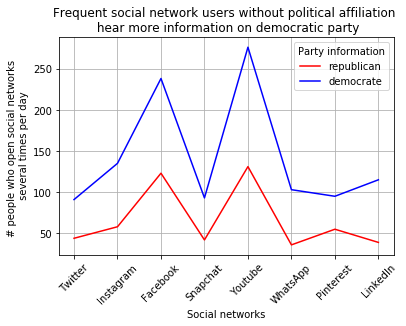

In [11]:
filt=data_Internet[(data_Internet["party"]>=3)]

users=pd.pivot_table(filt, values=['web1a', 'web1b','web1c', 'web1d','web1e', 'web1f', 'web1g', 'web1h'], index=['partyln'], \
aggfunc={'web1a': lambda x:''.join(x).count('1',0,-1),'web1b': lambda x:''.join(x).count('1',0,-1),\
         'web1c': lambda x:''.join(x).count('1',0,-1),'web1d': lambda x:''.join(x).count('1',0,-1),\
         'web1e': lambda x:''.join(x).count('1',0,-1),'web1f': lambda x:''.join(x).count('1',0,-1),\
         'web1g': lambda x:''.join(x).count('1',0,-1),'web1h': lambda x:''.join(x).count('1',0,-1)})
         

row =users.iloc[0]
x=row.plot(kind='line', color='red')
row =users.iloc[1]
row.plot(kind='line', color='blue')

plt.grid(True)

plt.legend(["republican", "democrate"], title="Party information", loc='upper right', frameon=True)
plt.xticks(rotation=45)

plt.xticks((0,1,2,3,4,5,6,7), ('Twitter','Instagram', 'Facebook', 'Snapchat', 'Youtube', 'WhatsApp', 'Pinterest', 'LinkedIn'))

x.set_xlabel("Social networks")
x.set_ylabel("# people who open social networks \n several times per day")
x.set_title("Frequent social network users without political affiliation \n hear more information on democratic party")


## Categorizing Partisan Leaning

My goal is  to "predict" the political inclination (Republican/Democratic) of the Twitter user from one of his/her tweets. The ground truth (i.e., true class labels) is determined from the tweets of the following accounts: realDonaldTrump, mike_pence, GOP, HillaryClinton, timkaine, TheDemocrats

realDonaldTrump, mike_pence, GOP are Republicans
HillaryClinton, timkaine, TheDemocrats are Democrats
Thus, this is a binary classification problem.

On the first step I did text processing and tokenizing of raw text. 

In [16]:
tag_map = {
        'CC':None, # coordin. conjunction (and, but, or)  
        'CD':wn.NOUN, # cardinal number (one, two)             
        'DT':None, # determiner (a, the)                    
        'EX':wn.ADV, # existential ‘there’ (there)           
        'FW':None, # foreign word (mea culpa)             
        'IN':wn.ADV, # preposition/sub-conj (of, in, by)   
        'JJ':[wn.ADJ, wn.ADJ_SAT], # adjective (yellow)                  
        'JJR':[wn.ADJ, wn.ADJ_SAT], # adj., comparative (bigger)          
        'JJS':[wn.ADJ, wn.ADJ_SAT], # adj., superlative (wildest)           
        'LS':None, # list item marker (1, 2, One)          
        'MD':None, # modal (can, should)                    
        'NN':wn.NOUN, # noun, sing. or mass (llama)          
        'NNS':wn.NOUN, # noun, plural (llamas)                  
        'NNP':wn.NOUN, # proper noun, sing. (IBM)              
        'NNPS':wn.NOUN, # proper noun, plural (Carolinas)
        'PDT':[wn.ADJ, wn.ADJ_SAT], # predeterminer (all, both)            
        'POS':None, # possessive ending (’s )               
        'PRP':None, # personal pronoun (I, you, he)     
        'PRP$':None, # possessive pronoun (your, one’s)    
        'RB':wn.ADV, # adverb (quickly, never)            
        'RBR':wn.ADV, # adverb, comparative (faster)        
        'RBS':wn.ADV, # adverb, superlative (fastest)     
        'RP':[wn.ADJ, wn.ADJ_SAT], # particle (up, off)
        'SYM':None, # symbol (+,%, &)
        'TO':None, # “to” (to)
        'UH':None, # interjection (ah, oops)
        'VB':wn.VERB, # verb base form (eat)
        'VBD':wn.VERB, # verb past tense (ate)
        'VBG':wn.VERB, # verb gerund (eating)
        'VBN':wn.VERB, # verb past participle (eaten)
        'VBP':wn.VERB, # verb non-3sg pres (eat)
        'VBZ':wn.VERB, # verb 3sg pres (eats)
        'WDT':None, # wh-determiner (which, that)
        'WP':None, # wh-pronoun (what, who)
        'WP$':None, # possessive (wh- whose)
        'WRB':None, # wh-adverb (how, where)
        '$':None, #  dollar sign ($)
        '#':None, # pound sign (#)
        '“':None, # left quote (‘ or “)
        '”':None, # right quote (’ or ”)
        '(':None, # left parenthesis ([, (, {, <)
        ')':None, # right parenthesis (], ), }, >)
        ',':None, # comma (,)
        '.':None, # sentence-final punc (. ! ?)
        ':':None # mid-sentence punc (: ; ... – -)
    }


def process(text, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    text1=''
    for w in text:
       text1=text1+w.lower()
    text2=text1
        
    text2=nltk.word_tokenize(text2)
    posit=nltk.pos_tag(text2)
    list1=[]
    for item, POS in posit: 
        list1.append(item)        
    return list1


def process_all(df, lemmatizer=nltk.stem.wordnet.WordNetLemmatizer()):
    df['text']=df['text'].apply(process)
    return df;
    
tweets = pd.read_csv("tweets_train.csv", na_filter=False)
processed_tweets = process_all(tweets)


Step2.

Text cleaning. I implemented a function which identifies rare words. I consider a word rare, if it occurs not more than three times in whole of tweets_train.csv.


In [20]:
def get_rare_words(processed_tweets):
    y=Counter()
    Twitter_text=processed_tweets['text']
    for r  in Twitter_text:
        y=y+Counter(r)
    rare_words=[]
    for w in y:
        if (y[w]<4):
           rare_words.append(w)
    rare_words.sort()
    return rare_words
    
def mirror_tokenizer(x):
    return x    

rare_words = get_rare_words(processed_tweets)

Feature construction and assigning labels. Features are created from words. Very common words and rare words are eliminated. 

I split the data to validation

In [24]:
def create_features(processed_tweets, rare_words):
    stop_words=nltk.corpus.stopwords.words('english')
    Cleared_processed_tweets=processed_tweets
    scop=[]
    for r in Cleared_processed_tweets['text']:
        r= [w for w in r if not w in stop_words]
        r= [w for w in r if not w in rare_words]
        scop=scop+[r]
    tfidf = sklearn.feature_extraction.text.TfidfVectorizer(tokenizer=mirror_tokenizer, lowercase=False)
    tfidf=tfidf.fit(scop)
    X=tfidf.transform(scop)
    return (tfidf, X)
    
def create_labels(processed_tweets):
    democrats=['HillaryClinton','TheDemocrats','timkaine']
    labels=[]
    for users in processed_tweets['screen_name']:
          if users in democrats:
            labels.append(0)
          else:
            labels.append(1)
    labels=np.asarray(labels)
    return labels

(tfidf, X) = create_features(processed_tweets, rare_words)
y = create_labels(processed_tweets)
total_number=len(processed_tweets['text'])
train_number=round(0.8*total_number)
random_vals=random.sample(range(total_number+1), train_number)
X_train=X[[i for i in range(0,total_number) if i in random_vals]]
X_valid=X[[i for i in range(0,total_number) if i not in random_vals]]
Y_train=y[[i for i in range(0,total_number) if i in random_vals]]
Y_valid=y[[i for i in range(0,total_number) if i not in random_vals]]

On the next step I perform classification using Support Vector Machine classifier.

In [25]:
def learn_classifier(X_train, y_train, kernel):
    init=sklearn.svm.classes.SVC(kernel=kernel)
    classifier=init.fit(X_train, y_train)
    return classifier


def evaluate_classifier(classifier, X_validation, y_validation):
    ev=classifier.predict(X_validation)
    accuracy=1-sum(abs(y_validation-ev)/len(ev))
    return accuracy
    
def classify_tweets(tfidf, classifier, unlabeled_tweets):
    scop=[]
    unlabeled=process_all(unlabeled_tweets)
    for r in unlabeled['text']:
        scop=scop+[r]
    X_unlabel=tfidf.transform(scop)
    predicted_label=classifier.predict(X_unlabel)
    return predicted_label

classifier = learn_classifier(X_train, Y_train, 'linear')
accuracy = evaluate_classifier(classifier, X_valid, Y_valid)
print(accuracy)

0.9110083790811906


#### Step4.

On the last step I scrapped data from Twitter for the last 24 hours with two hashtags: #Trump (political) and #coffee (non-political)

In [47]:
tweets_test = pd.read_csv("trump1.csv", na_filter=False)
processed_tweets_test = process_all(tweets_test)
y_pred = classify_tweets(tfidf, classifier, tweets_test)


In [48]:
dem=0
rep=0

for i in range(len(y_pred)):
    if (y_pred[i]==0):
        dem=dem+1
    if (y_pred[i]==1):
        rep=rep+1
        
print('#Trump Democrats ',dem)
print('#Trump Republicans ',rep)


Democrats  23744
Republicans  11658


In [49]:
dem=0
rep=0

tweets_test = pd.read_csv("coffee1.csv", na_filter=False)
processed_tweets_test = process_all(tweets_test)
y_pred = classify_tweets(tfidf, classifier, tweets_test)

for i in range(len(y_pred)):
    if (y_pred[i]==0):
        dem=dem+1
    if (y_pred[i]==1):
        rep=rep+1
        
print('#Coffee Democrats ',dem)
print('#Coffee Republicans ',rep)


#Coffee Democrats  15870
#Coffee Republicans  14320


We can see that for politically significant #Trump, there are more than twice more Democrats posts, and for politically non-significant #Coffee, there us about the same amount of tweets from both parties. It confirms our assumption that there are more Democratics news on Tweeter.